# Import necessary libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset 

In [5]:
# Load the Excel file containing the 6 tables
file_path = "C:/Users/Blu-Ray/Downloads/E-commerce_data.xlsx"

# Load each table from the Excel file
customers = pd.read_excel(file_path, sheet_name='customers')
genders = pd.read_excel(file_path, sheet_name='genders')
cities = pd.read_excel(file_path, sheet_name='cities')
transactions = pd.read_excel(file_path, sheet_name='transactions')
branches = pd.read_excel(file_path, sheet_name='branches')
merchants = pd.read_excel(file_path, sheet_name='merchants')

# Merge data to create a feature-rich dataframe

In [7]:
# Merging customers with transactions, genders, cities, and other relevant information
data = pd.merge(customers, transactions, on='customer_id', how='left')
data = pd.merge(data, genders, on='gender_id', how='left')
data = pd.merge(data, cities, on='city_id', how='left')

# 1) Feature engineering

1. Transaction frequency per customer (How many transactions each customer has)

In [20]:
transaction_frequency = data.groupby('customer_id')['transaction_id'].count().reset_index(name='transaction_frequency')
transaction_frequency

,customer_id,transaction_frequency
0,1.0,7
1,2.0,3
2,3.0,5
3,4.0,1
4,5.0,4
...,...,...
995,996.0,3
996,997.0,3
997,998.0,4
998,999.0,4


2. Coupon burn rate per customer (Ratio of burnt to claimed coupons)

In [21]:
data['burned'] = data['transaction_status'].apply(lambda x: 1 if x == 'burnt' else 0)
burn_rate = data.groupby('customer_id')['burned'].mean().reset_index(name='burn_rate')
burn_rate

,customer_id,burn_rate
0,1.0,0.0
1,2.0,0.0
2,3.0,0.0
3,4.0,0.0
4,5.0,0.0
...,...,...
995,996.0,0.0
996,997.0,0.0
997,998.0,0.0
998,999.0,0.0


3. Customer demographic features (gender and city)

In [22]:
customer_features = customers[['customer_id', 'gender_id', 'city_id']]
customer_features

,customer_id,gender_id,city_id
0,1.0,1.0,7.0
1,2.0,2.0,20.0
2,3.0,1.0,15.0
3,4.0,2.0,11.0
4,5.0,1.0,8.0
...,...,...,...
995,996.0,1.0,3.0
996,997.0,2.0,20.0
997,998.0,2.0,11.0
998,999.0,1.0,6.0


In [24]:
# Merge all features into a final dataset for clustering
features = pd.merge(customer_features, transaction_frequency, on='customer_id')
features = pd.merge(features, burn_rate, on='customer_id')

# Standardize the features for clustering
scaler = StandardScaler()
X = scaler.fit_transform(features[['gender_id', 'city_id', 'transaction_frequency', 'burn_rate']])

# 2) Model Development: K-Means Clustering

In [13]:
# Explore different numbers of clusters and calculate silhouette scores
silhouette_scores = []
inertia_scores = []
k_values = range(2, 11)  # Try 2 to 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
# Evaluation metrics
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    inertia_scores.append(kmeans.inertia_)    

# 3) Model Evaluation:Silhouette score and Inertia (for K-Means).

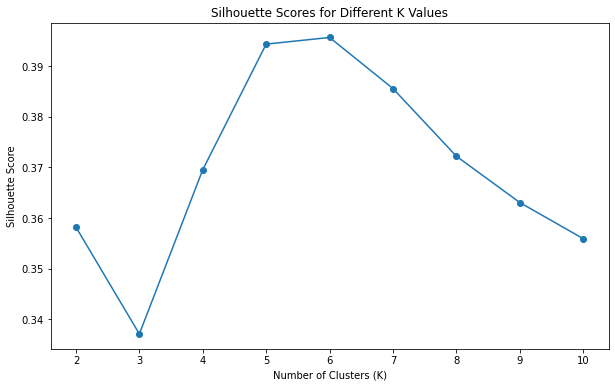

In [14]:
# Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

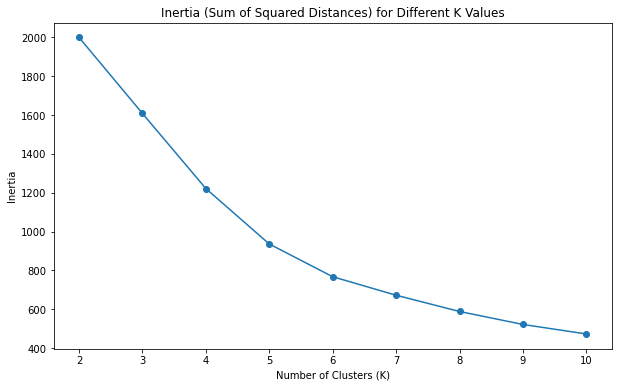

In [15]:
# Plot inertia to see the "elbow" for K-means clustering
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_scores, marker='o')
plt.title('Inertia (Sum of Squared Distances) for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [16]:
# Choose the best K based on the silhouette score and elbow method (let's assume K=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Add the cluster labels to the original data
features['cluster'] = clusters

# 4)Segment Analysis

In [17]:
#Describe customer behavior for each segment
segment_analysis = features.groupby('cluster').agg({
    'gender_id': 'mean',
    'city_id': 'mean',
    'transaction_frequency': 'mean',
    'burn_rate': 'mean'
}).reset_index()

print("Segment Analysis:\n", segment_analysis)

Segment Analysis:
    cluster  gender_id    city_id  transaction_frequency  burn_rate
0        0        1.0  15.561181               5.413502        0.0
1        1        2.0   5.158730               5.317460        0.0
2        2        1.0   5.349265               4.720588        0.0
3        3        2.0  15.451883               4.573222        0.0


In [18]:
# Recommendations for offering coupons:
# Higher burn_rate and transaction_frequency indicate more loyal customers
for i in range(optimal_k):
    segment = segment_analysis[segment_analysis['cluster'] == i]
    if segment['burn_rate'].values[0] > 0.7 and segment['transaction_frequency'].values[0] > 5:
        print(f"Cluster {i}: Consider offering high-value loyalty coupons.")
    elif segment['burn_rate'].values[0] > 0.5:
        print(f"Cluster {i}: Consider offering targeted discounts to boost loyalty.")
    else:
        print(f"Cluster {i}: Engage customers with personalized offers to increase activity.")

Cluster 0: Engage customers with personalized offers to increase activity.
Cluster 1: Engage customers with personalized offers to increase activity.
Cluster 2: Engage customers with personalized offers to increase activity.
Cluster 3: Engage customers with personalized offers to increase activity.


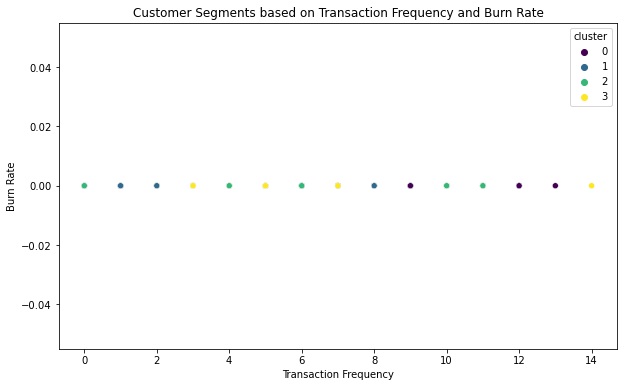

In [19]:
# Visualization of clusters (optional, for 2D plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features['transaction_frequency'], y=features['burn_rate'], hue=features['cluster'], palette='viridis')
plt.title('Customer Segments based on Transaction Frequency and Burn Rate')
plt.xlabel('Transaction Frequency')
plt.ylabel('Burn Rate')
plt.show()